# Gun Violence in US States, 2014-2017

- In this notebook, I'll take a closer look at US states. I'm interested in the discrepancy in per capita gun death rates on a state level.

In [2]:
import pandas as pd
import numpy as np
import requests 
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

I relied heavily on this article: https://medium.com/analytics-vidhya/web-scraping-wiki-tables-using-beautifulsoup-and-python-6b9ea26d8722

First, I'm going to read in my 'gun deaths by state' csv file as a Pandas dataframe:

In [4]:
gd = pd.read_csv('../data/gd_state.csv')

In [5]:
gd.head()

,state,n_killed
0,Alabama,1880
1,Alaska,267
2,Arizona,1094
3,Arkansas,773
4,California,5562


Now I'm going to start scraping Wikipedia for additional information. I'll start with a table of US states by population:

In [8]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population').text

I'll use beautiful soup to clean up the html:

In [9]:
soup = bs(url,'lxml')

Again, all I really want is the table on this site:

In [13]:
table = soup.find('table',{'class':'wikitable sortable'})

In [14]:
table_df = pd.read_html(str(table),header=0)

In [15]:
table_df = table_df[0]

Let's take a look at this dataframe:

In [16]:
table_df.head()

,"Rank in the fifty U.S. states, 2017","Rank in all U.S. states and territories, 2010",State or territory,"Population estimate, July 1, 2017[4]","Census population, April 1, 2010",Percent increase from 2010-2017[note 1],"Total seats in the U.S. House of Representatives, 2013–2023","Estimated population per electoral vote, 2017[note 2]","Estimated population per House seat, 2017","Census population per House seat, 2010","Percent of the total U.S. population, 2017[note 3]"
0,NaN,NaN,California,39536653,37252895,6.13%,NaN,718848,745974,702885,12.14%
1,NaN,NaN,Texas,28304596,25146105,12.56%,NaN,744858,786238,698503,8.69%
2,NaN,NaN,Florida,20984400,18804623,11.59%,NaN,734904,777200,696468,6.44%
3,NaN,NaN,New York,19849399,19378087,2.43%,NaN,684462,735163,717707,6.09%
4,NaN,NaN,Pennsylvania,12805537,12702887,0.81%,NaN,640277,711419,705715,3.93%


All I really want is each state's population from 2017, so i'm going to pare down my dataframe a great deal:

In [17]:
table_df = table_df[['State or territory', 'Population estimate, July 1, 2017[4]']]

And I'll go ahead and give these columns more reasonable names:

In [18]:
table_df.rename(columns={'State or territory':'state',
                           'Population estimate, July 1, 2017[4]':'pop'}, inplace=True)

Now this is starting to come together. I'll set the index to be the state names:

In [19]:
table_df.set_index('state', inplace=True)

But I still have a bunch of territories and non-states

In [20]:
table_df.tail(20)

,pop
state,
District of Columbia,693972
Vermont,623657
Wyoming,579315
Guam,"165,718[5]"
U.S. Virgin Islands,"104,914[7]"
American Samoa,"55,641[9]"
Northern Mariana Islands,"55,194[11]"
Wake Island,100
Palmyra Atoll,20


I'm just going to drop all of these:

In [21]:
table_df.drop(['Guam', 'Puerto Rico', 'U.S. Virgin Islands', 'American Samoa', 'Northern Mariana Islands',
              'Wake Island', 'Palmyra Atoll', 'Johnston Atoll', 'Baker Island', 'Howland Island', 'Midway Atoll',
              'Palmyra Atoll', 'Jarvis Island', 'Kingman Reef', 'Navassa Island', 'Contiguous United States', 
              'The fifty states', 'Fifty states + D.C.', 'Total U.S. (including D.C. and territories)'], 
              inplace=True)

In order to merge the populations with the gun deaths, I'm going to have to make sure they have the same index:

In [22]:
gd.set_index('state', inplace=True)

In [23]:
states = pd.merge(table_df, gd, left_index=True, right_index=True)

In [24]:
states.head()

,pop,n_killed
state,,
California,39536653,5562
Texas,28304596,5046
Florida,20984400,3909
New York,19849399,1705
Pennsylvania,12805537,2395


This looks good, but I need to make sure that all the columns are numeric.

In [25]:
states.dtypes

pop         object
n_killed     int64
dtype: object

In [26]:
states['pop'] = states['pop'].astype('int64')

Now I can make a 'per capita killed' column:

In [27]:
states['pc_killed'] = (states.n_killed / states['pop']) * 100000

In [28]:
states.head()

,pop,n_killed,pc_killed
state,,,
California,39536653,5562,14.067959
Texas,28304596,5046,17.827493
Florida,20984400,3909,18.628124
New York,19849399,1705,8.589681
Pennsylvania,12805537,2395,18.702847


Finally, I'll sort these by the 'pc_killed" column and save this dataframe as a csv so I can use it to create a Tableau plot later:

In [29]:
states_sorted = states.sort_values('pc_killed', ascending=False)
states_sorted.to_csv('../data/states_pc.csv')

I also want to make a barplot to better interpret how the states compare with one another. I'm going to highlight Maryland because I'll be focusing more on it later--Baltimore specifically--and I want to show how looking at per capita rates by states might not be granular enough for our purposes. 

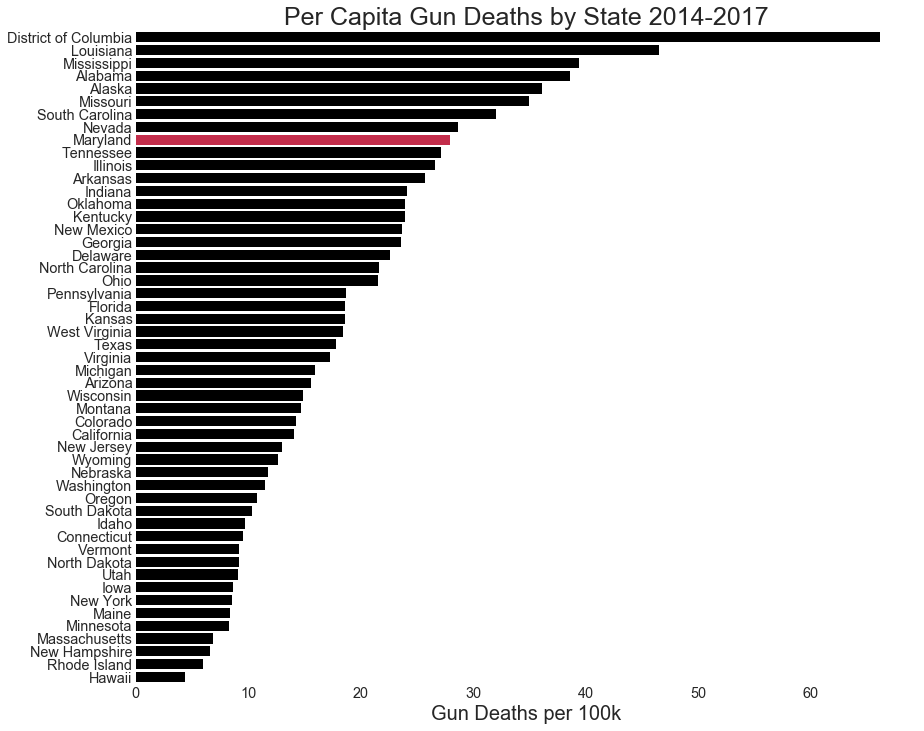

In [24]:
sns.set_style("white")
f, ax = plt.figure(figsize=(14,12)), plt.gca()
colors = colors = ['crimson' if x=='Maryland' else 'black' for x in states_sorted.index]
sns.barplot(x=states_sorted.pc_killed, y=states_sorted.index, data=states_sorted, palette=colors)
plt.title("Per Capita Gun Deaths by State 2014-2017", fontsize=25)
plt.xlabel("Gun Deaths per 100k", fontsize=20)
plt.ylabel('')
ax.tick_params(labelsize='x-large')
sns.despine(left=True, bottom=True)
plt.savefig('../images/states_pc.png');

These are cumulative numbers and won't give a good impression of year-to-year data. Let's look at 2017 specifically.

In [31]:
df = pd.read_csv('../data/guns2.csv', index_col=0)
df = df.loc['2017-01-01':'2017-12-31']

In [32]:
df = df.groupby('state')[['n_killed']].sum()
df = pd.merge(df, table_df, left_index=True, right_index=True)
df['pop'] = df['pop'].astype('int64')
df['pc_killed']= (df.n_killed / df['pop']) * 100000
df = df.sort_values('pc_killed', ascending=False)
df.head()

,n_killed,pop,pc_killed
state,,,
District of Columbia,100,693972,14.409803
Louisiana,549,4684333,11.719918
Alabama,544,4874747,11.159554
Mississippi,324,2984100,10.857545
Missouri,609,6113532,9.961508


I'll save this as a csv in case I need to use it for Tableau later:

In [33]:
df.to_csv('../data/states_pc_2017.csv')

Now I'm ready to plot again:

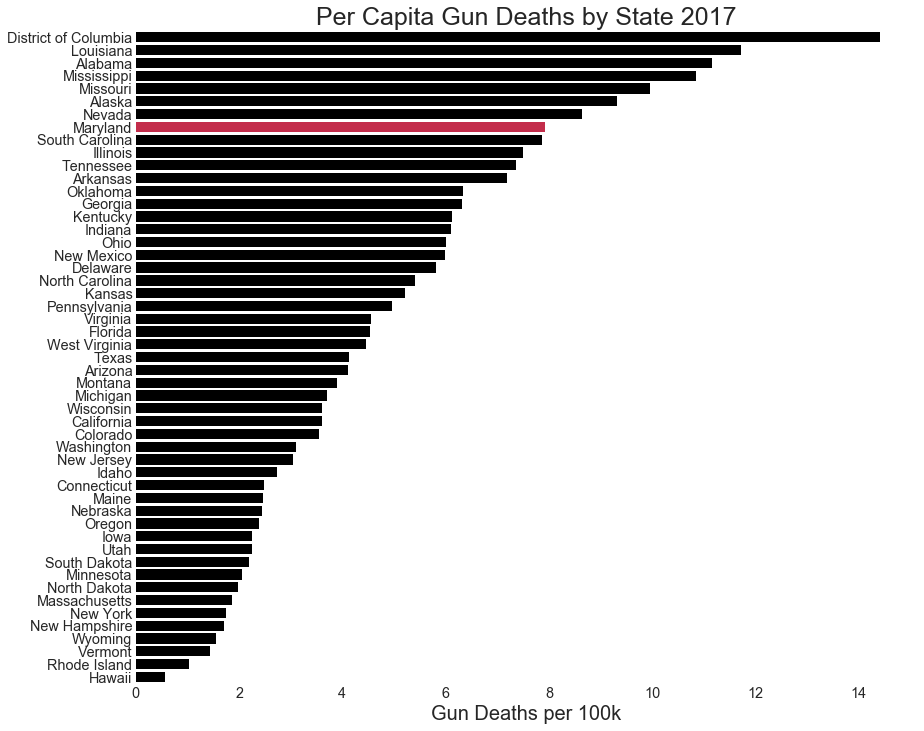

In [36]:
sns.set_style("white")
f, ax = plt.figure(figsize=(14,12)), plt.gca()
colors = colors = ['crimson' if x=='Maryland' else 'black' for x in df.index]
sns.barplot(x=df.pc_killed, y=df.index, data=df, palette=colors)
plt.title("Per Capita Gun Deaths by State 2017", fontsize=25)
plt.xlabel("Gun Deaths per 100k", fontsize=20)
plt.ylabel('')
ax.tick_params(labelsize='x-large')
sns.despine(left=True, bottom=True)
plt.savefig('../images/states_pc_2017.png');

The rankings are similar, but the per capita numbers are more helpful for my purposes. Really, these horizontal barplots aren't fun to look at, so this is why I'm going to make interactive Tableau plots. Those should be more useful in understanding which states are most violent from year to year and by how much.